In [1]:
import ee
import datetime
import time
import numba as nb
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
from tqdm import tnrange
from collections import Counter

# Authenticate to the Earth Engine servers.
ee.Initialize()

def timestamp_to_datetime(timestamp, time_format = '%Y-%m-%d'):
	return datetime.datetime.fromtimestamp(timestamp/1000).strftime(time_format)

def dates_available(geCollection):
    """
    Returns a list of the dates available for this collection.
    geCollection: ee.ImageCollection object
    Returns a list of date strings in YYYY-MM-DD format.
	Author: https://github.com/jldowns
    """
		
    timestamps =  geCollection.aggregate_array('system:time_start').getInfo()
    dateformat_array = [timestamp_to_datetime(t) for t in timestamps]
    return  dateformat_array
	
def available_bands(image_collection):
    """
    Returns a dictionary in format
    { "band1": { "number_available" : number of images that contain band1,
                 "percent_available" : percent of all images in collection that contain band1 }
                },
      "band2": {...
    }
	Author: https://github.com/jldowns
    """
	
    band_ids = [band_info['id'] for band_info in image_collection.first().getInfo()['bands']]
    collection_size = image_collection.size().getInfo()
    availability_dict = {}
    for b in band_ids:
        imgs_available = image_collection.select(b).size().getInfo()
        percent_available = imgs_available/collection_size*100
        availability_dict[b] = {
            "number_available": imgs_available,
            "percent_available": percent_available
        }
        # print( "'"+b+"' available in "+ str(imgs_available) + " images. ("+str(percent_available)+"%)")

    return availability_dict


def export_image(img, loc, name, scale, crs):
	"""
	Export an image from Earth Engine to my Google Drive
	"""
	task = ee.batch.Export.image.toDrive(img, name, folder=loc, scale=scale, crs=crs)
	task.start()
	while task.status()['state'] == 'RUNNING':
		#print('Running...')		
		# Perhaps task.cancel() at some point.
		time.sleep(10)
	#print('Done.', task.status())

def appendBand(current, previous):
	"""
	Transforms an Image Collection with 1 band per Image into a single Image with items as bands
	Author: Jamie Vleeshouwer
	"""
	# Rename the band
	previous = ee.Image(previous)
	current = current
    # Append it to the result (Note: only return current item on first element/iteration)
	accum = ee.Algorithms.If(ee.Algorithms.IsEqual(previous,None), current, previous.addBands(ee.Image(current)))
    # Return the accumulation
	return accum

def merge_img_array(arr_1, nband_1, arr_2, nband_2):
    """
    Merge images from difference arrays of 2D images. (ex. one has 7, the other has 2, both of them has 500 temporal images, then 
    we merge to a list of 500 temporal images with 9 bands.) The variable arr_1 is the main one.
    """
    m = arr_1.shape[0]
    n = arr_1.shape[1]
    l1 = arr_1.shape[2]
    l2 = arr_2.shape[2]
    merged_arr = np.empty((m, n, l1+l2))
    
    
    for i in range(int(l1/nband_1)):
        position_1 = i*nband_1 + i*nband_2
        position_2 = position_1 + nband_1
        merged_arr[:, :, position_1 : position_1+nband_1] = arr_1[:, :, i*nband_1 : i*nband_1+nband_1]
        merged_arr[:, :, position_2 : position_2+nband_2] = arr_2[:, :, i*nband_2 : i*nband_2+nband_2]
        
    # Check before done
    clause_1 = np.all(np.equal(merged_arr[:, :, 0:nband_1], arr_1[:, :, 0:nband_1]))
    clause_2 = np.all(np.equal(merged_arr[:, :, -nband_2:], arr_2[:, :, -nband_2:]))
    if (clause_1 == True) and (clause_2 == True):
        #print('done')
        pass
    else:
        raise ValueError('A very specific bad thing happened. Maybe the number of given band is wrong?')
    return merged_arr
	
	
#@nb.jit
def get_img_per_yr(dates_of_images):
    
    """ Return a dictionary of year with counts of images in that year.
    The input must be a list of date string in a formart of 'yyyy-mm-dd'"""
    
    years = [date[0:4] for date in dates_of_images]
    unique_year = list(np.unique(years))
    years = {year:years.count(year) for year in unique_year}
    
    return years


def get_year_dim(years, nband):
    
    """ Get a list of [start, stop] for dimensions of bands in each year for a given amount of years.
    Input years is a dictionary from get_img_per_yr"""

    year_list = sorted(years.keys())
    dimensions = [[years[year]*nband*year_list.index(year), years[year]*nband*year_list.index(year) + years[year]*nband] for year in years]
    
    return dimensions 


def filter_year(year_range, img, nband, dates_of_images):
    
    """ Return the image with specify year range and the year is [inclusive, exclusive]"""
    
    # need to do this cause we use dictionary keys to reference
    year_range[1] = str(int(year_range[1]) - 1)
    
    years = get_img_per_yr(dates_of_images)
    year_dim = get_year_dim(years, nband)
    year_list = sorted(years.keys())
    
    if np.all(year_range[0] not in year_list or year_range[1] not in year_list):
        raise(ValueError('The given year is out of bound for the given set of image.'))
        
    start = year_dim[year_list.index(year_range[0])][0]
    stop = year_dim[year_list.index(year_range[1])][1] #<-- compensate for the -1 earlier
    new_img = img[:, :, start: stop]
    new_dates_of_images = [date for date in dates_of_images if date[0:4] in \
                          [str(year) for year in range(int(year_range[0]), int(year_range[1]) + 1)]]

    return new_img, new_dates_of_images

def split_img_by_year(img, nband, dates_of_images):
    
    """Return a list of image separated by year from a single stacked-by-year image"""
    
    years = get_img_per_yr(dates_of_images)
    year_dim = get_year_dim(years, nband)
    img_list = [img[:, :, dim[0]:dim[1]] for dim in year_dim]
    return img_list
    
def count_img_nan(img):
    
    """ Check and count the number of nan in the image, will return nothing if 
    there is no nan, but will retur number if there is a nan"""
    
    return np.count_nonzero(np.isnan(img))

def norm_to_zero_one(arr):
    return (arr - np.nanmin(arr)) * 1.0 / (np.nanmax(arr) - np.nanmin(arr))

def normalize_impute_image(img):
    
    #plt.imshow(img[:, :, band])
    #plt.show()
    #img_df = norm_to_zero_one(pd.DataFrame(img))
    img = norm_to_zero_one(img)
    #print(count_img_nan(test_img))
    img = SoftImpute(max_iters=300, verbose=0).complete(img)
    if count_img_nan(img) > 0:
        print('There is a problem with band {}'.format(band))
    return img

@nb.jit
def zero_fill(img):
    for band in range(img.shape[2]):
        img[:, :, band] = np.nan_to_num(img[:, :, band])
    return img

@nb.jit
def mask_img(img, mask):
    for band in range(len(img.shape[2])):
        img[:, :, band] = img[:, :, band] * mask[:, :, :]
		
		
def plt_img_dist(file_dir, nband, nsample, yield_dataframe):
    import random
    """
    Return data for plotting the distribution of the number in each band of a set of images in a folder.
    Image is in a form of npy format. 
    """
    
    fips = yield_dataframe[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][yield_dataframe['YEAR'] >= 2010].values
    rand_idx = random.sample(range(0, len(fips)), nsample)
    data = {band:[] for band in range(0, nband)}
    for i, _ in enumerate(tqdm(fips[rand_idx])):
        #file = random.choice(os.listdir("D://projectII_temp_data//MODIS_LAND"))
        try:
            test = np.load(file_dir + str(fips[i][0]) + '_' + str(fips[i][1]) + '_' + str(fips[i][2]) + '.npy')
            for band in range(nband):
                data[band] = np.append(data[band], test[:, :, band].ravel())
                data[band] = data[band][np.nonzero(data[band])]
        except: # In case it hits [51,131] or [46, 102]
            pass
    return data
	
def get_stats(file_dir, nband, nsample, yield_dataframe):
    
    import random

    avg_MODIS_LAND = {band:[] for band in range(0, nband)}  # average per images (38 images per year for MODIS)
    std_MODIS_LAND = {band:[] for band in range(0, nband)}
    count_MODIS_LAND = {band:[] for band in range(0, nband)}
    
    avg_year = {band:[] for band in range(0, nband)}   # yearly average (for plotting)
    var_year = {band:[] for band in range(0, nband)}
    max_year = {band:[] for band in range(0, nband)}
    count_year = {band:[] for band in range(0, nband)}
    
    avg_total = {band:[] for band in range(0, nband)}     # Total average (for statistical analysis)
    std_total = {band:[] for band in range(0, nband)} 
    
    yield_ = []
    nband = nband
    nsample = nsample

    fips = yield_dataframe[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][yield_dataframe['YEAR'] >= 2010
                                                                  and yield_dataframe['YEAR'] <= 2017].values #JLedit
    rand_idx = random.sample(range(0, len(fips)), nsample)
    for i, _ in enumerate(fips[rand_idx]):
        try:
            test = np.load(file_dir + str(fips[i][0]) + '_' + str(fips[i][1]) + '_' + str(fips[i][2]) + '.npy')
            yield_ += [yield_dataframe['YIELD'][(yield_dataframe['STATE_FIPS'] == int(fips[i][1])) & (yield_dataframe['COUNTY_FIPS'] == int(fips[i][2])) \
                                          & (yield_dataframe['YEAR'] == int(fips[i][0]))].values]
            for band in range(nband):
                bands = list(np.arange(band, test.shape[2], nband)) 
                non_zero_index = test[:, :, bands].nonzero()
                count_year[band] += [len(non_zero_index[0])]
                avg_year[band] += [test[:, :, bands][non_zero_index].mean()]
                var_year[band] += [test[:, :, bands][non_zero_index].var()]
                max_year[band] += [test[:, :, bands].max()]

        except:
            pass

    for band in range(nband):
        # Delete NaN (i.e. samples that do not have any corn in that year)
        nan_idx = np.argwhere(np.isnan(avg_year[band]))
        avg_year[band] = np.delete(avg_year[band], nan_idx)
        var_year[band] = np.delete(var_year[band], nan_idx)
        count_year[band] = np.delete(count_year[band], nan_idx)
        

        avg_total[band] = np.sum(avg_year[band]*np.array(count_year[band]))/ np.sum(count_year[band])
        std_total[band] = np.sqrt(np.sum(var_year[band]*np.array(count_year[band]))/ np.sum(count_year[band]))
        
    yield_ = np.delete(yield_, nan_idx)       
    return avg_year, count_year, max_year, yield_, avg_total, std_total
	
def get_bin(img, lims, nband, resolution):
    """Making an image taken for a number of time in a year and convert 
    it to bins. The result has a dimension of 
    (nbands, resolution of bin, imgs per year)"""
    
    y = np.zeros((nband, resolution, int(img.shape[2]/nband)))
    for time in range(int(img.shape[2]/nband)):
        for lim, band in zip(lims, range(nband)):
            bins = np.array(np.linspace(lim[0], lim[1], resolution))
            x = img[:, :, band + time*nband][np.nonzero(img[:, :, band + time*nband])]
            x = np.digitize(x.ravel(), bins)
            count = Counter(x)
            y[band, :, time] = np.array([count[i+1] for i in range(resolution)])/len(x)
    return y

In [11]:
#import bqplot
import datetime
import time
import ee
from IPython.display import display, IFrame, Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from helper_functions import *
from skimage.viewer import ImageViewer
from skimage.io import imread
from imageio import imwrite
import pprint
# from tqdm import tqdm
# from tqdm import tnrange
from tqdm import tqdm, tnrange
import numba as nb
#from fancyimpute import KNN, SoftImpute
from sklearn.preprocessing import normalize, StandardScaler
import pylab
from scipy.stats import normaltest, shapiro, anderson, skew
import seaborn as sns
import random
#from os import listdir
#from os.path import isfile, join
from matplotlib import gridspec
import statsmodels.api as sm
from skimage.io import imread
import glob
from scipy.stats import normaltest
import os


pp = pprint.PrettyPrinter(depth=4)
tqdm.monitor_interval = 0

# Authenticate to the Earth Engine servers.
ee.Initialize()


SMALL_SIZE = 11
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



In [12]:
ee.Initialize()

In [122]:
corn_grain = pd.read_csv('./data/corn-grain.csv')
corn_grain.head()
corn_grain_2018 = corn_grain[corn_grain['YEAR'] == 2018]
corn_grain_2018 = corn_grain_2018.groupby('STATE').mean().reset_index()
corn_grain_2018[['STATE', 'YIELD_BU_ACRE']]
corn_grain_2018['STATE'] = [state[0:2] for state in corn_grain_2018['STATE']]
corn_grain_2018.shape

(32, 8)

NormaltestResult(statistic=array([487.08298294]), pvalue=array([1.70323331e-106]))

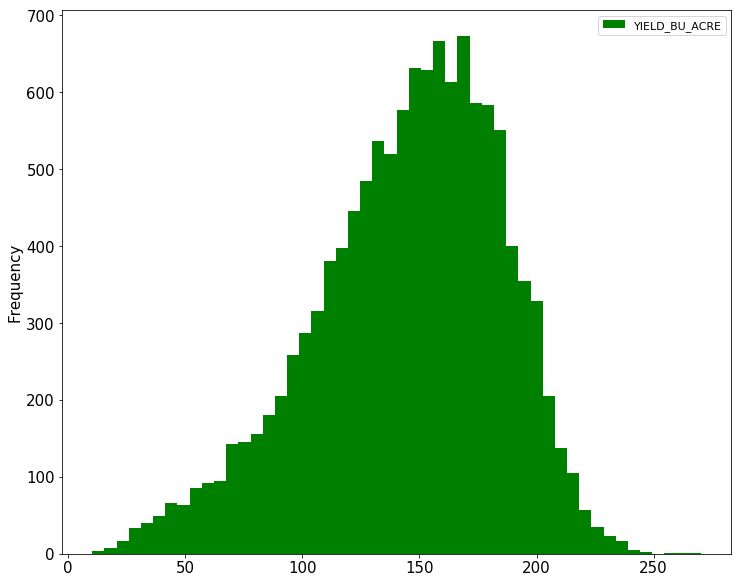

In [84]:
# Corn yields distribution across U.S.

corn_grain[['YIELD_BU_ACRE']].plot.hist(bins=50, color='g')
normaltest(corn_grain[['YIELD_BU_ACRE']].values.tolist())

In [61]:
import pandas as pd
import folium
 
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it

county_geo = os.path.join('.', 'data/shapefiles', 'gz_2010_us_050_00_500k.json')
state_geo = os.path.join('.', 'data/shapefiles', 'us-states.json')
isfile(state_geo)

True

In [123]:
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it
 
# Load the unemployment value of each state
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
state_unemployment = os.path.join('.', 'data', 'US_Unemployment_Oct2012.csv')

state_data = pd.read_csv(state_unemployment)
state_data.shape

(50, 2)

In [113]:
state_geo

'./data/shapefiles/us-states.json'

In [114]:
# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)

In [120]:
 
# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=corn_grain_2018,
 columns=['STATE', 'YIELD_BU_ACRE'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Corn Yield (bu/acre)'
)
folium.LayerControl().add_to(m)
 
# Save to html
m.save('corn_yield_state_map.html')

In [15]:
unique_data = sorted([list(x) for x in set(tuple(x) for x in corn_grain[['STATE_FIPS', 'COUNTY_FIPS']].values)])
unique_data[:8]

[[1, 1], [1, 3], [1, 5], [1, 9], [1, 11], [1, 13], [1, 15], [1, 19]]

In [16]:
fips_data = [location for location in unique_data if location not in [[46, 102], [51, 131]]] #51, 131 = All nan, 46, 102 = no results
len(fips_data)

print('There are a total of {} states with {} counties in the dataset.'.format(len(corn_grain['STATE_FIPS'].unique()), len(unique_data)))

There are a total of 37 states with 2003 counties in the dataset.


In [17]:
# Getting county level information and statistics
# Note that the function is designed for more than one pic --> becareful with USDA which only give 1 pic per year

target_sat = {'USDA/NASS/CDL':['cropland'],
              'MODIS/006/MYD11A2':[0,4],
              'MODIS/006/MOD09A1':[0,1,2,3,4,5,6]
        }

folders = ['USDA_CROP',
           'MODIS_TEMP',
           'MODIS_LAND'
           ]

locations = [(loc[0], loc[1]) for loc in unique_data]
dates = ['2011-1-2', '2019-7-4']
scale = 500 #meters/pixel
dates_of_images = {folder:[] for folder in folders} #initialize empty dictionary with folder names as keys

In [18]:
county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')

for folder, target in zip(folders, target_sat):

    if folder == 'USDA_CROP':
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1])\
                        .select(target_sat[target]) 
    else:
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1])\
                        .select(target_sat[target])\
                        .filter(ee.Filter.calendarRange(3,12,'month'))

    # append bands to each image when collected
    img = img_collection.iterate(appendBand)
    if folder == 'USDA_CROP':
        img = ee.Image(img).eq(1)  # only corn 
    else:
        img = ee.Image(img)

    # print basic info (bands and no. of available images)
    dates_of_images[folder] += dates_available(img_collection)
    print('\n ######################### ' + target +  ' #########################')
    print("Total Dates Available: ", len(dates_of_images[folder]))
    print("Dates available: ", dates_of_images[folder])

    collection_bands = available_bands(img_collection)
    for k, v in collection_bands.items():
        print("Band", k, "will be downloaded in", v['number_available'], "images per county. (", v['percent_available'], "%)")
    
#     if False:
#         # Getting images
#         for i, (loc1, loc2) in enumerate(locations):

#             im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
#             scale  = scale
#             crs = 'EPSG:4326'   # Coordinate Reference System

#             # filter for a county
#             region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
#             region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
#             region = ee.Feature(region.first()) # get the coordinates and other features

#             while True:
#                 try:
#                     export_image(img.clip(region), folder, im_name, scale, crs)
#                 except Exception:
#                     print(Exception)
#                     time.sleep(10)
#                     continue
#                 break
#             if (i%250 == 0) or (i == len(locations)-1):
#                 print(i)        


 ######################### USDA/NASS/CDL #########################
Total Dates Available:  7
Dates available:  ['2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31']
Band cropland will be downloaded in 7 images per county. ( 100.0 %)

 ######################### MODIS/006/MYD11A2 #########################
Total Dates Available:  319
Dates available:  ['2011-03-05', '2011-03-13', '2011-03-21', '2011-03-29', '2011-04-06', '2011-04-14', '2011-04-22', '2011-04-30', '2011-05-08', '2011-05-16', '2011-05-24', '2011-06-01', '2011-06-09', '2011-06-17', '2011-06-25', '2011-07-03', '2011-07-11', '2011-07-19', '2011-07-27', '2011-08-04', '2011-08-12', '2011-08-20', '2011-08-28', '2011-09-05', '2011-09-13', '2011-09-21', '2011-09-29', '2011-10-07', '2011-10-15', '2011-10-23', '2011-10-31', '2011-11-08', '2011-11-16', '2011-11-24', '2011-12-02', '2011-12-10', '2011-12-18', '2011-12-26', '2012-03-04', '2012-03-12', '2012-03-20', '2012-03-28', '2012-04-05', 

Band sur_refl_b01 will be downloaded in 319 images per county. ( 100.0 %)
Band sur_refl_b02 will be downloaded in 319 images per county. ( 100.0 %)
Band sur_refl_b03 will be downloaded in 319 images per county. ( 100.0 %)
Band sur_refl_b04 will be downloaded in 319 images per county. ( 100.0 %)
Band sur_refl_b05 will be downloaded in 319 images per county. ( 100.0 %)
Band sur_refl_b06 will be downloaded in 319 images per county. ( 100.0 %)
Band sur_refl_b07 will be downloaded in 319 images per county. ( 100.0 %)


In [124]:
# For moisture content because the collection time is not the same as MODIS, we created a time interval (+-4 days) of the MODIS image and take median out of that
# to be incorporated with MODIS.

# creating time intervals
backward = datetime.timedelta(days=-4)
date_list = [datetime.date(int(date.split('-')[0]), int(date.split('-')[1]), int(date.split('-')[2])) + backward for date in dates_of_images['MODIS_LAND']] 
date_list += [date_list[-1] - backward]

# changing to list and string format
date_list = ['{}-{}-{}'.format(date.year, date.month, date.day) for date in date_list]
date_list = [[date_list[i], date_list[i+1]] for i in range(len(date_list)-1)]

folder = 'USDA_MOISTURE'
#dates_of_images[folder] = date_list
locations = [(loc[0], loc[1]) for loc in unique_data]
scale  = scale   # 500m = 1 pixel

#################################################################################################

county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')
print('Total Dates {}'.format(len(date_list)))
for i, dates in enumerate(date_list):
    
    if i == 0:
        img = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                        .filterDate(dates[0], dates[1]) \
                        .select([0, 1]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))\
                        .median()
    else:
        img2 = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                    .filterDate(dates[0], dates[1]) \
                    .select([0, 1]) \
                    .filter(ee.Filter.calendarRange(3,12,'month'))\
                    .median()
        img = img.addBands(img2)
        
print('There are {} total number of images'.format(len(img.bandNames().getInfo())))

Total Dates 319
There are 638 total number of images


In [125]:
#DO NOT DELETE THIS
# # Getting images
# for i, (loc1, loc2) in enumerate(locations):

#     im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
#     scale  = scale
#     crs = 'EPSG:4326'   # Coordinate Reference System

#     # filter for a county
#     region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
#     region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
#     region = ee.Feature(region.first()) # get the coordinates and other features

#     while True:
#         try:
#             export_image(img.clip(region), folder, im_name, scale, crs)
#         except Exception:
#             print(Exception)
#             time.sleep(10)
#             continue
#         break
#     if (i%500 == 0) or (i == len(locations)-1):
#         print(i)

In [126]:
#data_path = '/media/james/tbhdd/Google Drive/'
data_path = '/home/james/ledermau@gmail.com/EarthEngine/'

USDA_CROP_path = data_path + 'USDA_CROP/'
USDA_MOISTURE_path = data_path + 'USDA_MOISTURE/'
MODIS_TEMP_path = data_path + 'MODIS_TEMP/'
MODIS_LAND_path = data_path + 'MODIS_LAND/'

folder_list = [USDA_CROP_path, USDA_MOISTURE_path, MODIS_TEMP_path, MODIS_LAND_path]

for folder in folder_list:
    print("Files in {}: {}".format(folder, len(listdir(folder))))

Files in /home/james/ledermau@gmail.com/EarthEngine/USDA_CROP/: 2002
Files in /home/james/ledermau@gmail.com/EarthEngine/USDA_MOISTURE/: 2002
Files in /home/james/ledermau@gmail.com/EarthEngine/MODIS_TEMP/: 2002
Files in /home/james/ledermau@gmail.com/EarthEngine/MODIS_LAND/: 2002


In [127]:
#import matplotlib as plt
test_county = '19_57' #des moines
#path = ['MODIS_LAND/MODIS_LAND_', 'MODIS_TEMP/MODIS_TEMP_', 'USDA_MOISTURE/USDA_MOISTURE_', 'USDA_CROP/USDA_CROP_']
path = ['USDA_CROP/USDA_CROP_', 'MODIS_LAND/MODIS_LAND_']

In [130]:
test = imread(USDA_CROP_path + listdir(USDA_CROP_path)[0])
file

'MODIS_LAND/MODIS_LAND_'

<function matplotlib.pyplot.show(*args, **kw)>

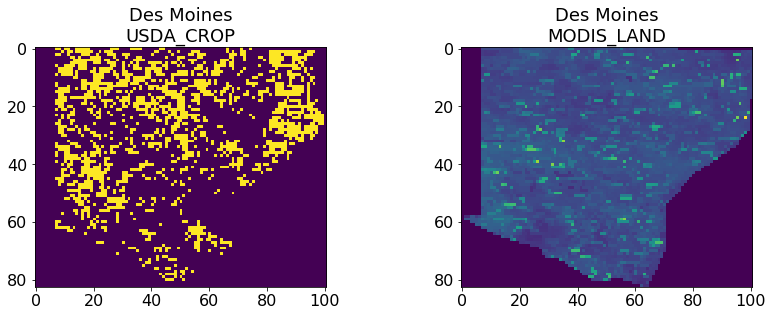

In [24]:
plt.rcParams['figure.figsize'] = [12, 8]
for i, file in enumerate(path):
    test = imread(data_path + file + test_county + '.tif')
    plt.subplot(2,2, i+1)
    plt.imshow(test[:, :, 0], )
    plt.title('Des Moines\n' + file.split('/')[1][:-1], fontsize=18)
    #plt.colorbar()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
plt.savefig('Example Images', dpi=500)
plt.tight_layout(1.04)
plt.show

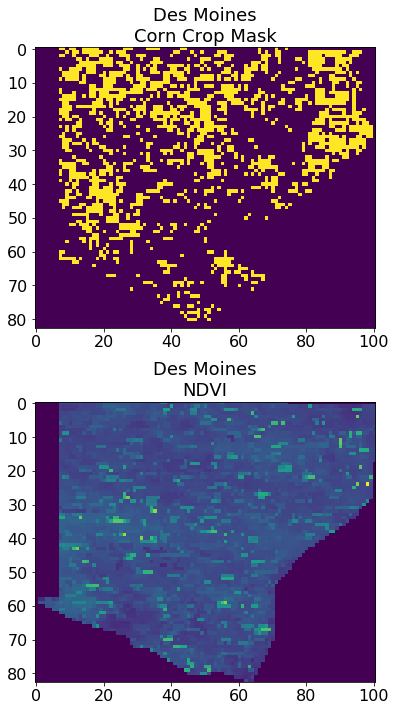

In [25]:
plt.rcParams['figure.figsize'] = [12, 10]
for i, file in enumerate(path):
    test = imread(data_path + file + test_county + '.tif')
    plt.subplot(2,1, i+1)
    plt.imshow(test[:, :, 0], )
    plt.title('Des Moines\n' + ['Corn Crop Mask', 'NDVI'][i], fontsize=18)
    #plt.colorbar()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
plt.savefig('Example Images', dpi=500)
plt.tight_layout(1.04)
plt.show()

In [132]:
# Processing image (this one I didn't rerun cause it takes forever)

@nb.jit
def image_processing_I(filedata):
    path, folder, nband, fips_data, dates_of_images = filedata
    new_dates = {}
    for state, county in tqdm(fips_data):
        # Create path
        imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif' 
        imname_folder_2 = folder[2] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_3 = folder[3] + '_' + str(state) + '_' + str(county) + '.tif'

        # Reading figures
        mask = imread(path + folder[0] + '/' + imname_mask)
        img_1 = imread(path + folder[1] + '/' + imname_folder_1)
        img_2 = imread(path + folder[2] + '/' + imname_folder_2)
        img_3 = imread(path + folder[3] + '/' + imname_folder_3)

        # Lets do just 2010-2016 first
        mask, new_dates[folder[0]] = filter_year(['2011', '2018'], mask, nband[0], dates_of_images[folder[0]])
        img_1, new_dates[folder[1]] = filter_year(['2011', '2018'], img_1, nband[1], dates_of_images[folder[1]])
        img_2, new_dates[folder[2]] = filter_year(['2011', '2018'], img_2, nband[2], dates_of_images[folder[2]])

        # Making sure the bands of the figure are correct
        if (img_1.shape[2]/nband[1] != img_2.shape[2]/nband[2]) \
        or img_1.shape[2]/nband[1] != img_3.shape[2]/nband[3]:
            print(img_1.shape[2]/nband[1], img_2.shape[2]/nband[2], img_3.shape[2]/nband[3])
            raise ValueError('Dimension of the matrix is not correct.')

        # Zero fill NaN
        img_3 = zero_fill(img_3)

        if count_img_nan(img_3) > 0:
            print('The number of NaN in MODIS_LAND, Temp, and USDA_MOISTURE and CROP are {}, {}, and {}, {}. \
            in {} state and {} county'.format(count_img_nan(img_1), count_img_nan(img_2), count_img_nan(img_3), \
                                              count_img_nan(mask), state, county))

        # Splitting images by year
        img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
        img_2_list = split_img_by_year(img_2, nband[2], new_dates[folder[2]])
        img_3_list = split_img_by_year(img_3, nband[3], new_dates[folder[1]])

        # Masking
        for i, img_year in enumerate(img_1_list):
            for j in range(img_year.shape[2]):
                img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_2_list):
            for j in range(img_year.shape[2]):
                img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_3_list):
            for j in range(img_year.shape[2]):
                img_3_list[i][:, :, j] = img_3_list[i][:, :, j] * mask[:, :, i]
        
        year_list = list(range(2010, 2017))
        # export images, this part can be improved by using HDF5
        for i, img_year in enumerate(img_1_list):
            np.save(output_path + folder[1] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        for i, img_year in enumerate(img_2_list):
            np.save(output_path + folder[2] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        for i, img_year in enumerate(img_3_list):
            np.save(output_path + folder[3] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
            
if __name__ == "__main__":
    path = data_path
    folder = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP', 'USDA_MOISTURE']
    nband = [1, 7, 2, 2]
    output_path = '/home/james/git/cornacle/data/preprocessed'
    filedata = path, folder, nband, fips_data, dates_of_images
    
    image_processing_I(filedata)
    

  0%|          | 0/2001 [00:00<?, ?it/s]

266.0 266.0 318.0


ValueError: Dimension of the matrix is not correct.

In [131]:
path = data_path
folder = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP', 'USDA_MOISTURE']
nband = [1, 7, 2, 2]
output_path = '/home/james/git/cornacle/data/temp/'
filedata = path, folder, nband, fips_data, dates_of_images
filedata

('/home/james/ledermau@gmail.com/EarthEngine/',
 ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP', 'USDA_MOISTURE'],
 [1, 7, 2, 2],
 [[1, 1],
  [1, 3],
  [1, 5],
  [1, 9],
  [1, 11],
  [1, 13],
  [1, 15],
  [1, 19],
  [1, 21],
  [1, 29],
  [1, 31],
  [1, 33],
  [1, 35],
  [1, 39],
  [1, 41],
  [1, 43],
  [1, 45],
  [1, 47],
  [1, 49],
  [1, 51],
  [1, 53],
  [1, 55],
  [1, 57],
  [1, 59],
  [1, 61],
  [1, 63],
  [1, 65],
  [1, 67],
  [1, 69],
  [1, 71],
  [1, 75],
  [1, 77],
  [1, 79],
  [1, 83],
  [1, 87],
  [1, 89],
  [1, 91],
  [1, 95],
  [1, 97],
  [1, 99],
  [1, 101],
  [1, 103],
  [1, 105],
  [1, 107],
  [1, 109],
  [1, 111],
  [1, 113],
  [1, 117],
  [1, 119],
  [1, 121],
  [1, 123],
  [1, 125],
  [1, 127],
  [1, 129],
  [1, 131],
  [5, 1],
  [5, 3],
  [5, 17],
  [5, 21],
  [5, 29],
  [5, 31],
  [5, 33],
  [5, 35],
  [5, 37],
  [5, 41],
  [5, 43],
  [5, 45],
  [5, 47],
  [5, 55],
  [5, 63],
  [5, 67],
  [5, 69],
  [5, 71],
  [5, 73],
  [5, 75],
  [5, 77],
  [5, 79],
  [5, 83],
  [5, 85]

In [133]:
new_dates ={}
#tqdm(fips_data)
state, county = fips_data[1]
state, county

(1, 3)

In [139]:
imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
#mask = imread(path + folder[0] + '/' + imname_mask)
imname_mask
mask = imread(os.path.join('.', data_path, 'USDA_CROP', imname_mask))

In [140]:
mask, new_dates[folder[0]] = filter_year(['2011', '2018'], mask, nband[0], dates_of_images[folder[0]])
count_img_nan(mask)

0

In [141]:
imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif'
#print(imname_folder_1)
img_1 = imread(path + folder[1] + '/' + imname_folder_1)
#print(img_1)
img_1, new_dates[folder[1]] = filter_year(['2011', '2018'], img_1, nband[1], dates_of_images[folder[1]])

In [142]:
img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
for i, img_year in enumerate(img_1_list):
            for j in range(img_year.shape[2]):
                img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]


In [143]:
output_path

'/home/james/git/cornacle/data/preprocessed'

In [150]:
folders


['USDA_CROP', 'MODIS_TEMP', 'MODIS_LAND']

In [144]:
year_list = list(range(2011, 2018))
for i, img_year in enumerate(img_1_list):
    np.save(os.path.join(output_path + folders[1] + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 

FileNotFoundError: [Errno 2] No such file or directory: '/home/james/git/cornacle/data/preprocessedMODIS_LAND//2011_1_3.npy'

[2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [ ]:
# Using this to try and get specific missing images...
target_sat = {'USDA/NASS/CDL':['cropland'],
              'MODIS/006/MYD11A2':[0,4],
              'MODIS/006/MOD09A1':[0,1,2,3,4,5,6]
}


In [ ]:
for i in target_sat:
    print(i)

In [ ]:
dates_available

In [ ]:
#folder = 'USDA_CROP'; target = 'USDA/NASS/CDL'
folder = 'MODIS_TEMP'; target = 'MODIS/006/MYD11A2'
#folder = 'MODIS_LAND'; target = 'MODIS/006/MOD09A1'

loc1 = 1 #State FIPS
loc2 = 5 #County FIPS


county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')

if folder == 'USDA_CROP':
    img_collection = ee.ImageCollection(target)\
                    .filterDate(dates[0], dates[1])\
                    .select(target_sat[target]) 
else:
    img_collection = ee.ImageCollection(target)\
                    .filterDate(dates[0], dates[1])\
                    .select(target_sat[target])\
                    .filter(ee.Filter.calendarRange(3,12,'month'))

# append bands to each image when collected
img = img_collection.iterate(appendBand)
if folder == 'USDA_CROP':
    img = ee.Image(img).eq(1)  # only corn 
else:
    img = ee.Image(img)

# print basic info (bands and no. of available images)
dates_of_images[folder] += dates_available(img_collection)
print('\n ######################### ' + target +  ' #########################')
print("Total Dates Available: ", len(dates_of_images[folder]))
print("Dates available: ", dates_of_images[folder])

collection_bands = available_bands(img_collection)
for k, v in collection_bands.items():
    print("Band", k, "will be downloaded in", v['number_available'],
          "images per county. (", v['percent_available'], "%)")

im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
scale  = scale
crs = 'EPSG:4326'   # Coordinate Reference System

# filter for a county
region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
region = ee.Feature(region.first()) # get the coordinates and other features

In [ ]:
# while True:
#     try:
#         export_image(img.clip(region), folder, im_name, scale, crs)
#     except Exception:
#         print(Exception)
#         time.sleep(10)
#         continue
#     break        

In [ ]:
folders

In [ ]:
mask = folders[0] + '_' + str(state) + '_' + str(county) + '.tif'
missing = []
for folder in folders:
    for state, county in tqdm(fips_data):
        imname = folder + '_' + str(state) + '_' + str(county) + '.tif'
        img_fullpath = "{}{}/{}".format(path, folder, imname)
        if imname not in os.listdir(path + folder):
            
            #print("Image found: {}".format(img_fullpath))
            #image = imread(path + folder + '/' + imname)
            #plt.imshow(image[:,:,5])

        #else:
            print("Image not found: {}".format(img_fullpath))
            missing.append(img_fullpath)

In [ ]:
fips_data_test = [row for row in fips_data if row[0] == 19]

In [ ]:
fips_data_test

In [ ]:
# Processing images
#LEAVING OUT MOISTURE FOR NOW
@nb.jit
def image_processing_I(filedata):
    path, folders, nband, fips_data, dates_of_images = filedata
    new_dates = {}
    for state, county in tqdm(fips_data):
        # Create path
        imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif' 
        imname_folder_2 = folder[2] + '_' + str(state) + '_' + str(county) + '.tif'
        #imname_folder_3 = folder[3] + '_' + str(state) + '_' + str(county) + '.tif'

        # Reading figures       
        mask = imread(path + folder[0] + '/' + imname_mask)
        img_1 = imread(path + folder[1] + '/' + imname_folder_1)
        img_2 = imread(path + folder[2] + '/' + imname_folder_2)
        #img_3 = imread(path + folder[3] + '/' + imname_folder_3)

        # Lets do just 2010-2016 first
        mask, new_dates[folder[0]] = filter_year(['2011', '2018'], mask, nband[0], dates_of_images[folder[0]])
        img_1, new_dates[folder[1]] = filter_year(['2011', '2018'], img_1, nband[1], dates_of_images[folder[1]])
        img_2, new_dates[folder[2]] = filter_year(['2011', '2018'], img_2, nband[2], dates_of_images[folder[2]])

        # Making sure the bands of the figure are correct
        if (img_1.shape[2]/nband[1] != img_2.shape[2]/nband[2]): #or img_1.shape[2]/nband[1] != img_3.shape[2]/nband[3]:
            print(img_1.shape[2]/nband[1], img_2.shape[2]/nband[2])#, img_3.shape[2]/nband[3])
            raise ValueError('Dimension of the matrix is not correct.')

        # Zero fill NaN
        #img_3 = zero_fill(img_3)

        #if count_img_nan(img_3) > 0:
        #    print('The number of NaN in MODIS_LAND, Temp, and USDA_MOISTURE and CROP are {}, {}, and {}, {}. \
        #    in {} state and {} county'.format(count_img_nan(img_1), count_img_nan(img_2), count_img_nan(img_3), \
         #                                     count_img_nan(mask), state, county))

        # Splitting images by year
        img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
        img_2_list = split_img_by_year(img_2, nband[2], new_dates[folder[2]])
        #img_3_list = split_img_by_year(img_3, nband[3], new_dates[folder[1]])

        # Masking
        for i, img_year in enumerate(img_1_list):
            for j in range(img_year.shape[2]):
                img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_2_list):
            for j in range(img_year.shape[2]):
                img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]
        #for i, img_year in enumerate(img_3_list):
        #    for j in range(img_year.shape[2]):
        #        img_3_list[i][:, :, j] = img_3_list[i][:, :, j] * mask[:, :, i]
        
        year_list = list(range(2011, 2018))
        # export images, this part can be improved by using HDF5
        for i, img_year in enumerate(img_1_list):
            np.save(output_path + folder[1] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        for i, img_year in enumerate(img_2_list):
            np.save(output_path + folder[2] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        #for i, img_year in enumerate(img_3_list):
        #    np.save(output_path + folder[3] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
            
if __name__ == "__main__":
    path = data_path
    folder = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP']#, 'USDA_MOISTURE']
    nband = [1, 7, 2]#, 2]
    output_path = '/home/james/git/cornacle/data/temp/'
    filedata = path, folders, nband, fips_data_test, dates_of_images
    
    image_processing_I(filedata)

#### Original

In [ ]:
#ORIGINAL

# # Processing image (this one I didn't rerun cause it takes forever)

# @nb.jit
# def image_processing_I(filedata):
#     path, folder, nband, fips_data, dates_of_images = filedata
#     new_dates = {}
#     for state, county in tqdm(fips_data):
#         # Create path
#         imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
#         imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif' 
#         imname_folder_2 = folder[2] + '_' + str(state) + '_' + str(county) + '.tif'
#         imname_folder_3 = folder[3] + '_' + str(state) + '_' + str(county) + '.tif'

#         # Reading figures
#         mask = imread(path + folder[0] + '/' + imname_mask)
#         img_1 = imread(path + folder[1] + '/' + imname_folder_1)
#         img_2 = imread(path + folder[2] + '/' + imname_folder_2)
#         img_3 = imread(path + folder[3] + '/' + imname_folder_3)

#         # Lets do just 2010-2016 first
#         mask, new_dates[folder[0]] = filter_year(['2011', '2018'], mask, nband[0], dates_of_images[folder[0]])
#         img_1, new_dates[folder[1]] = filter_year(['2011', '2018'], img_1, nband[1], dates_of_images[folder[1]])
#         img_2, new_dates[folder[2]] = filter_year(['2011', '2018'], img_2, nband[2], dates_of_images[folder[2]])

#         # Making sure the bands of the figure are correct
#         if (img_1.shape[2]/nband[1] != img_2.shape[2]/nband[2]) \
#         or img_1.shape[2]/nband[1] != img_3.shape[2]/nband[3]:
#             print(img_1.shape[2]/nband[1], img_2.shape[2]/nband[2], img_3.shape[2]/nband[3])
#             raise ValueError('Dimension of the matrix is not correct.')

#         # Zero fill NaN
#         img_3 = zero_fill(img_3)

#         if count_img_nan(img_3) > 0:
#             print('The number of NaN in MODIS_LAND, Temp, and USDA_MOISTURE and CROP are {}, {}, and {}, {}. \
#             in {} state and {} county'.format(count_img_nan(img_1), count_img_nan(img_2), count_img_nan(img_3), \
#                                               count_img_nan(mask), state, county))

#         # Splitting images by year
#         img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
#         img_2_list = split_img_by_year(img_2, nband[2], new_dates[folder[2]])
#         img_3_list = split_img_by_year(img_3, nband[3], new_dates[folder[1]])

#         # Masking
#         for i, img_year in enumerate(img_1_list):
#             for j in range(img_year.shape[2]):
#                 img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]
#         for i, img_year in enumerate(img_2_list):
#             for j in range(img_year.shape[2]):
#                 img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]
#         for i, img_year in enumerate(img_3_list):
#             for j in range(img_year.shape[2]):
#                 img_3_list[i][:, :, j] = img_3_list[i][:, :, j] * mask[:, :, i]
        
#         year_list = list(range(2011, 2018))
#         # export images, this part can be improved by using HDF5
#         for i, img_year in enumerate(img_1_list):
#             np.save(output_path + folder[1] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
#         for i, img_year in enumerate(img_2_list):
#             np.save(output_path + folder[2] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
#         for i, img_year in enumerate(img_3_list):
#             np.save(output_path + folder[3] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
            
# if __name__ == "__main__":
#     path = data_path
#     folder = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP', 'USDA_MOISTURE']
#     nband = [1, 7, 2, 2]
#     output_path = '/home/james/git/cornacle/data/temp'
#     filedata = path, folder, nband, fips_data, dates_of_images
    
#     image_processing_I(filedata)

In [ ]:
# #ORIGINAL
# # Plotting distribution of band values in 3000 images

# plt_MODIS_LAND = plt_img_dist('D://projectII_temp_data//MODIS_LAND//', 7, 3000, corn_grain)
# plt_MODIS_TEMP = plt_img_dist('D://projectII_temp_data//MODIS_TEMP//', 2, 3000, corn_grain)
# plt_USDA_MOISTURE = plt_img_dist('D://projectII_temp_data//USDA_MOISTURE//', 2, 3000, corn_grain)

# cm = pylab.get_cmap('viridis')
# band_name = {'MODIS_LAND': [1,2,3,4,5,6,7],
#              'MODIS_TEMP': ['Day land surface temperature', 'Night land surface temperature'],
#              'USDA_MOISTURE': ['Surface Moisture', 'Subsurface Moisture']}
# nband = [7, 2, 2]
# plt_files = [plt_MODIS_LAND, plt_MODIS_TEMP, plt_USDA_MOISTURE]
# xlabel = ['Spectral Reflectance', 'Surface Temperature (Kelvin)', 'Soil Moisture (mm)']

# f, axs = plt.subplots(1, 3, figsize=(25,6))

# for i, (name, plt_file) in enumerate(zip(band_name, plt_files)):
#     cm = pylab.get_cmap('magma')
    
#     for band in range(nband[i]):
#         color = cm(1.*band/nband[i])
#         _, p = normaltest(plt_file[band])
#         sns.distplot(plt_file[band], color=color, ax=axs[i], bins=100, \
#                      kde_kws={"label": 'Band {}: {} , p-value={:.4f}.'.format(band, band_name[name][band], p)})
        
#     axs[i].set_xlabel(xlabel[i], fontsize=MEDIUM_SIZE)
#     axs[i].set_ylabel('Normalized Frequency', fontsize=MEDIUM_SIZE)
    
# plt.tight_layout()
# plt.savefig('band distribution', dpi=500)
# plt.show()

In [ ]:
data_out_path = '/home/james/git/cornacle/data/temp/'

In [ ]:
listdir(data_out_path)

In [ ]:
file_dir = data_out_path + 'MODIS_LAND/'
i = 0
fips[i][0]

In [ ]:
fips = [row for row in fips if row[0] !=2018]

In [ ]:

test = np.load(file_dir + str(fips[i][0]) + '_' + str(fips[i][1]) + '_' + str(fips[i][2]) + '.npy')
test

In [ ]:
# Plotting distribution of band values in 3000 images

plt_MODIS_LAND = plt_img_dist(data_out_path + 'MODIS_LAND', 7, 3000, corn_grain)
plt_MODIS_TEMP = plt_img_dist(data_out_path + 'MODIS_TEMP', 2, 3000, corn_grain)

In [ ]:
plt_MODIS_LAND

In [ ]:
data_out_path

In [ ]:
file_dir

In [ ]:
#plt_MODIS_LAND = plt_img_dist('D://projectII_temp_data//MODIS_LAND//', 7, 3000, corn_grain)
#plt_MODIS_TEMP = plt_img_dist('D://projectII_temp_data//MODIS_TEMP//', 2, 3000, corn_grain)
#plt_USDA_MOISTURE = plt_img_dist('D://projectII_temp_data//USDA_MOISTURE//', 2, 3000, corn_grain)
file_dir = '/home/james/git/cornacle/data/temp/MODIS_LAND/'
nband = 7
nsample = 3000
yield_dataframe = corn_grain

#def plt_img_dist(file_dir, nband, nsample, yield_dataframe):
#    import random
#    """
#    Return data for plotting the distribution of the number in each band of a set of images in a folder.
#    Image is in a form of npy format. 
#    """
    
fips = yield_dataframe[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][yield_dataframe['YEAR'] >= 2010].values

In [ ]:
fips = [row for row in fips if row[0] <2018]

In [ ]:
fips = np.array(fips)

In [ ]:
rand_idx = random.sample(range(0, len(fips)), nsample)
rand_idx

In [ ]:
fips[rand_idx]

In [ ]:
data = {band:[] for band in range(0, nband)}

In [ ]:
str(fips[i][0])

In [ ]:
i[1]

In [ ]:
for i in tqdm(fips[rand_idx]):
#file = random.choice(os.listdir("D://projectII_temp_data//MODIS_LAND"))
    try:
        test = np.load(file_dir + str(i[0]) + '_' + str(i[1]) + '_' + str(i[2]) + '.npy')
        for band in range(nband):
                data[band] = np.append(data[band], test[:, :, band].ravel())
                data[band] = data[band][np.nonzero(data[band])]
    except: # In case it hits [51,131] or [46, 102]
        pass

    
    # return data

In [ ]:
plt_MODIS_LAND = data

In [ ]:
# for i, _ in enumerate(tqdm(fips[rand_idx])):
#     #file = random.choice(os.listdir("D://projectII_temp_data//MODIS_LAND"))
#     try:
#         test = np.load(file_dir + str(fips[i][0]) + '_' + str(fips[i][1]) + '_' + str(fips[i][2]) + '.npy')
#         for band in range(nband):
#             data[band] = np.append(data[band], test[:, :, band].ravel())
#             data[band] = data[band][np.nonzero(data[band])]
#     except: # In case it hits [51,131] or [46, 102]
#         pass
# return data

In [ ]:
cm = pylab.get_cmap('viridis')
band_name = {'MODIS_LAND': [1,2,3,4,5,6,7],
             'MODIS_TEMP': ['Day land surface temperature', 'Night land surface temperature']}
             #,
             #'USDA_MOISTURE': ['Surface Moisture', 'Subsurface Moisture']}
nband = [7, 2]#, 2]
plt_files = [plt_MODIS_LAND, plt_MODIS_TEMP]#, plt_USDA_MOISTURE]
xlabel = ['Spectral Reflectance', 'Surface Temperature (Kelvin)']#, 'Soil Moisture (mm)']

f, axs = plt.subplots(1, 3, figsize=(25,6))

for i, (name, plt_file) in enumerate(zip(band_name, plt_files)):
    cm = pylab.get_cmap('magma')
    
    for band in range(nband[i]):
        color = cm(1.*band/nband[i])
        _, p = normaltest(plt_file[band])
        sns.distplot(plt_file[band], color=color, ax=axs[i], bins=100, \
                     kde_kws={"label": 'Band {}: {} , p-value={:.4f}.'.format(band, band_name[name][band], p)})
        
    axs[i].set_xlabel(xlabel[i], fontsize=MEDIUM_SIZE)
    axs[i].set_ylabel('Normalized Frequency', fontsize=MEDIUM_SIZE)
    
plt.tight_layout()
plt.savefig('band distribution', dpi=500)
plt.show()

In [ ]:
file_dir

In [ ]:
files = listdir(file_dir)
test = np.load(file_dir+files[7])
test.shape
listdir(file_dir)
files = listdir(path)    
#    fips = yield_dataframe[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][yield_dataframe['YEAR'] >= 2010].values

#rand_idx = random.sample(range(len(files)), nsample)
len(files)

In [ ]:
def plt_img_dist(path, nband, yield_dataframe):
#    """
#    Return data for plotting the distribution of the number in each band of a set of images in a folder.
 #   Image is in a form of npy format. 
  #  """
    files = listdir(path)    

    data = {band:[] for band in range(0, nband)}
    for filename in tqdm(files):
        try:
            test = np.load(path + filename)
            for band in range(nband):
                    data[band] = np.append(data[band], test[:, :, band].ravel())
                    data[band] = data[band][np.nonzero(data[band])]
        except:
            pass

        return data
################
plt_MODIS_LAND = plt_img_dist('/home/james/git/cornacle/data/temp/MODIS_LAND/', 7, corn_grain)
plt_MODIS_TEMP = plt_img_dist('/home/james/git/cornacle/data/temp/MODIS_TEMP/', 2, corn_grain)

cm = pylab.get_cmap('viridis')
band_name = {'MODIS_LAND': [1,2,3,4,5,6,7],
             'MODIS_TEMP': ['Day land surface temperature', 'Night land surface temperature']}
             #,
             #'USDA_MOISTURE': ['Surface Moisture', 'Subsurface Moisture']}
nband = [7, 2]#, 2]
plt_files = [plt_MODIS_LAND, plt_MODIS_TEMP]#, plt_USDA_MOISTURE]
xlabel = ['Spectral Reflectance', 'Surface Temperature (Kelvin)']#, 'Soil Moisture (mm)']

f, axs = plt.subplots(1, 2, figsize=(25,10))

for i, (name, plt_file) in enumerate(zip(band_name, plt_files)):
    cm = pylab.get_cmap('magma')
    
    for band in range(nband[i]):
        color = cm(1.*band/nband[i])
        _, p = normaltest(plt_file[band])
        sns.distplot(plt_file[band], color=color, ax=axs[i], bins=100, \
                     kde_kws={"label": 'Band {}: {} , p-value={:.4f}.'.format(band, band_name[name][band], p)})
        
    axs[i].set_xlabel(xlabel[i], fontsize=MEDIUM_SIZE)
    axs[i].set_ylabel('Normalized Frequency', fontsize=MEDIUM_SIZE)
    
plt.tight_layout()
plt.savefig('band distribution', dpi=500)
plt.show()

In [ ]:
def get_stats(file_dir, nband, nsample, yield_dataframe):
    
    import random

    avg_MODIS_LAND = {band:[] for band in range(0, nband)}  # average per images (38 images per year for MODIS)
    std_MODIS_LAND = {band:[] for band in range(0, nband)}
    count_MODIS_LAND = {band:[] for band in range(0, nband)}
    
    avg_year = {band:[] for band in range(0, nband)}   # yearly average (for plotting)
    var_year = {band:[] for band in range(0, nband)}
    max_year = {band:[] for band in range(0, nband)}
    count_year = {band:[] for band in range(0, nband)}
    
    avg_total = {band:[] for band in range(0, nband)}     # Total average (for statistical analysis)
    std_total = {band:[] for band in range(0, nband)} 
    
    yield_ = []
    nband = nband
    nsample = nsample

    fips = yield_dataframe[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][yield_dataframe['YEAR'] >= 2010].values
    rand_idx = random.sample(range(0, len(fips)), nsample)
    for i, _ in enumerate(fips[rand_idx]):
        try:
            test = np.load(file_dir + str(fips[i][0]) + '_' + str(fips[i][1]) + '_' + str(fips[i][2]) + '.npy')
            yield_ += [yield_dataframe['YIELD'][(yield_dataframe['STATE_FIPS'] == int(fips[i][1])) & (yield_dataframe['COUNTY_FIPS'] == int(fips[i][2])) \
                                          & (yield_dataframe['YEAR'] == int(fips[i][0]))].values]
            for band in range(nband):
                bands = list(np.arange(band, test.shape[2], nband)) 
                non_zero_index = test[:, :, bands].nonzero()
                count_year[band] += [len(non_zero_index[0])]
                avg_year[band] += [test[:, :, bands][non_zero_index].mean()]
                var_year[band] += [test[:, :, bands][non_zero_index].var()]
                max_year[band] += [test[:, :, bands].max()]

        except:
            pass

    for band in range(nband):
        # Delete NaN (i.e. samples that do not have any corn in that year)
        nan_idx = np.argwhere(np.isnan(avg_year[band]))
        avg_year[band] = np.delete(avg_year[band], nan_idx)
        var_year[band] = np.delete(var_year[band], nan_idx)
        count_year[band] = np.delete(count_year[band], nan_idx)
        

        avg_total[band] = np.sum(avg_year[band]*np.array(count_year[band]))/ np.sum(count_year[band])
        std_total[band] = np.sqrt(np.sum(var_year[band]*np.array(count_year[band]))/ np.sum(count_year[band]))
        
    yield_ = np.delete(yield_, nan_idx)       
    return avg_year, count_year, max_year, yield_, avg_total, std_total



path = '/home/james/git/cornacle/data/temp/MODIS_LAND/'
avg_year_LAND, count_year_LAND, max_year_LAND, yield_LAND, avg_total_LAND, std_total_LAND = \
get_stats(path, 7, len(listdir(path)), corn_grain)

path = '/home/james/git/cornacle/data/temp/MODIS_TEMP/'
avg_year_TEMP, count_year_TEMP, max_year_TEMP, yield_TEMP, avg_total_TEMP, std_total_TEMP =\
get_stats(path, 2, len(listdir(path)), corn_grain)

#avg_year_MOISTURE, count_year_MOISTURE, max_year_MOISTURE, yield_MOISTURE, avg_total_MOISTURE, std_total_MOISTURE =\
#get_stats('D://projectII_temp_data//USDA_MOISTURE//', 2, nsample, corn_grain)